In [2]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d import dft_core
from cdft.lj_eos import lj_eos
from numba import vectorize

device = torch.device('cuda')

In [3]:
sigma = 3.73
epsilon = 148.0
parameters = {'sigma':sigma, 'epsilon':epsilon}

In [4]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.12/site-packages/pymatgen/io/cif.py:1290: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [5]:
T = 300.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters, T, system_size, points, device)

In [6]:
forcefield = pd.DataFrame()
forcefield['type'] = ['Zn','H','C','O']
forcefield['sigma'] = np.array([4.045, 2.846, 3.47299, 3.033])
forcefield['epsilon'] = np.array([27.677, 7.6489, 47.8562, 48.1581])
forcefield['mass'] = np.array([65.38, 1.00784, 12.0107, 15.999])

X,Y,Z = np.meshgrid(dft.x, dft.y, dft.z, indexing='ij')

@vectorize
def lj_potential(r,sigma,epsilon):
    if r == 0:
        V = np.inf
    elif r > 12.9:
        V = 0.0
    else:
        V = 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 
    return V 

Vext = np.zeros((points[0], points[1], points[2]), dtype=np.float64)
for k, site in enumerate(structure):
    sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
    epsilonsf = float(np.sqrt(epsilon*forcefield['epsilon'][forcefield['type']==site.species_string]))
    rx = X-structure.cart_coords[k,0] 
    ry = Y-structure.cart_coords[k,1] 
    rz = Z-structure.cart_coords[k,2] 
    rx -= system_size[0]*(rx/system_size[0]).round()
    ry -= system_size[1]*(ry/system_size[1]).round()
    rz -= system_size[2]*(rz/system_size[2]).round()
    r = np.sqrt(rx**2+ry**2+rz**2)
    Vext += lj_potential(r,sigmasf,epsilonsf)

/tmp/ipykernel_6069/135069438.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_6069/135069438.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilonsf = float(np.sqrt(epsilon*forcefield['epsilon'][forcefield['type']==site.species_string]))
/tmp/ipykernel_6069/135069438.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_6069/135069438.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) ins

Text(0, 0.5, '$y$ (\\AA{})')

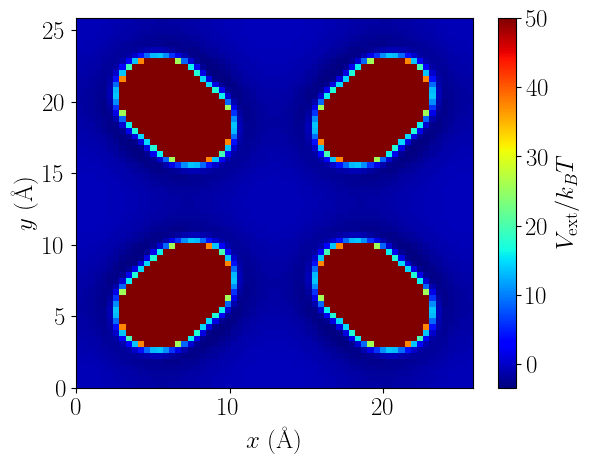

In [7]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(X[:,:,points[0]//2],Y[:,:,points[1]//2],Vext[:,:,points[2]//2]/T, vmax=50.0, cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [8]:
P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))
bulk_density = torch.empty_like(P)
composition = torch.tensor([1.0],dtype=torch.float64)

eos = lj_eos(parameters, T)
bulk_density[0] = eos.density(P[0],'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],bulk_density[i-1])

/tmp/ipykernel_6069/3813163443.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  P = torch.hstack((torch.arange(1e5,1e6,1e5,dtype=torch.float64), torch.range(1e6,1e7,1e6,dtype=torch.float64)))


In [9]:
dft.initial_condition(bulk_density[0],Vext)

In [10]:
Nads = torch.empty(len(P),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],fmt='ASWB',
                                    solver='fire',alpha0=0.2,dt=0.1,tol=1e-6,logoutput=False)
    Nads[i] = dft.total_molecules
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[i].numpy())
    if np.isnan(dft.error.numpy()): break

90 4.5453889695330166e-08 1.0 2.6779044063273014
89 4.976274987963125e-07 2.0 5.362009427083908
89 1.3484652436926746e-07 3.0000000000000004 8.044690543401
88 5.653832166780679e-07 4.0 10.719014193911898
88 5.478130842418871e-07 5.0 13.378612978485801
90 3.1661095927283414e-07 6.000000000000001 16.01765977489594
89 4.233251745232685e-07 7.000000000000001 18.630853507077084
86 5.654314752897891e-07 8.0 21.21339929527204
88 9.519088720584605e-07 9.0 23.76094559607143
86 5.652957724183376e-07 10.0 26.269650175247335
138 8.568322311839437e-07 20.0 48.70069679639822
113 9.925613169932394e-07 30.000000000000004 65.93891490080257
131 9.978123716804649e-07 40.0 78.79028543605128
112 9.938014321862588e-07 50.00000000000001 88.45531641891857
112 5.994476030649449e-07 60.00000000000001 95.8996173904068
128 8.797253035098434e-07 70.0 101.78911814555224
110 9.844638476553279e-07 80.0 106.56620941987123
113 9.649539479584781e-07 90.00000000000001 110.52647918708192
105 9.805569026089397e-07 100.0000

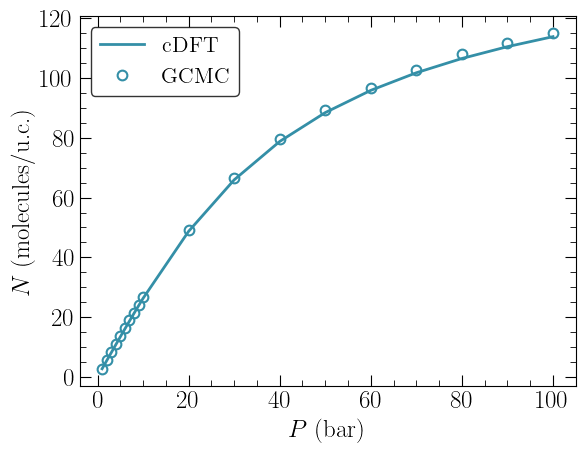

In [13]:
data = pd.read_pickle('data/isotherm_methane.pkl')

import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P*1e-5, Nads, '-', color=colors[3], linewidth=2.0, label='cDFT')
plt.plot(data['pressure'], data['methane'], 'o', color=colors[3],markersize=7,markeredgewidth=1.5,mfc='none',label='GCMC')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,125])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')